# Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Preproceessing


>[0, 1, 2, 3, 6, 9, 11, 13, 16, 27, 31, 32, 34, 35, 51] are features with Information of *timestamp*, *Port*, *IP-address*, *payload*. <br>
>[54, 55] *mqtt.proto_len* and *mqtt.protoname* are same in meaning. Similarly *mqtt.topic_len* and *mqtt.topic* (one in numerics and other in string). <br>
>[11, 20, 45, 51, 60, 61] *icmp.unused*, *http.tls_port*, *dns.retransmit_request_in*, *mqtt.msg_decoded_as*, *mbtcp.trans_id*, *mbtcp.unit_id* are features with only *0* as value. <br>
>Dataset have Fault with Features *Frametime* and *arp.hw.size*. Both have their values exchanged sometimes. <br>
>Categorical Features have values '0' and '0.0', which are practically same, hence united before encoding. <br>
>Removed Target Labels *Attack_label* and *Attack_type*. <br>
 

In [2]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0')
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    # Removing Duplicates
    duplicate_index = Raw_Data.duplicated()
    Raw_Data = Raw_Data[~duplicate_index]
    Raw_Data, attack_label, attack_type = Raw_Data[~duplicate_index], attack_label[~duplicate_index], attack_type[~duplicate_index]

    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

# Functions

In [3]:
# multiclass classifiers evaluation
def evaluate_clf(model, model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels= model.classes_, normalize= None)
        plt.title(model_name)
    return df_metric

# Binary classifiers evaluation
def evaluate_bin(model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    if model_name == 'LOF':
        test_novel = np.where(test == 0, -1, 1)
        tn, fp, fn, tp = metrics.confusion_matrix(test_novel, pred, labels=[1,-1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_novel, pred)*100,                              
                                'Precision':metrics.precision_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test_novel, pred, pos_label= -1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100},
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test_novel, pred, display_labels=['Normal', 'Anomaly'], normalize= 'true')
            plt.title(model_name)
    else:
        tn, fp, fn, tp = metrics.confusion_matrix(test, pred, labels=[0,1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                                'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100}, 
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Anomaly'], normalize= 'true')
            plt.title(model_name)
    return df_metric

# Scoring function for LOF
def custom_scorer(clf, x, y):
    y_prd = clf.predict(x)
    y = y.replace({0:1, 1:-1})
    cm = metrics.confusion_matrix(y, y_prd)
    tn, fp, fn, tp = cm.ravel()
    f1 = metrics.f1_score(y, y_prd, pos_label= -1)
    roc = metrics.roc_auc_score(y, y_prd)
    # Composite score
    score = f1
    return score

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class SampleSubsetSelector(BaseEstimator, TransformerMixin):
    def __init__(self, max_train_samples=6000):
        self.max_train_samples = max_train_samples
        self.is_train = True  # Default to training mode

    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer

    def transform(self, X, y=None):
        if self.is_train and y is not None:
            if len(X) > self.max_train_samples:
                X, _, y, _ = train_test_split(X, y, train_size=self.max_train_samples, stratify=y, random_state=22)       
        return (X, y) if y is not None else X

    def set_is_train(self, is_train=True):
        self.is_train = is_train

# Binary pipelines

## Normal

In [5]:
# Encoders and Scalers
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
numerical_transformer_std = StandardScaler()
categorical_transformer_tar = TargetEncoder()

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('Robust Scaling numerical features', numerical_transformer_rob, numerical_features), # robust scaling
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])
transformer_pass_tar = ColumnTransformer(
    transformers=[
        ('passthrough numerical features', 'passthrough', numerical_features), # passthrough
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])

# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_LOF = Pipeline([
    ('subsample', SampleSubsetSelector(6000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', LocalOutlierFactor(novelty= True, leaf_size= 6, metric= 'manhattan', n_neighbors= 2))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF)], voting='soft')

# Dictionary of pipelines
pipelines = {
    'Vote': Vote_clf,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'LOF': Pipeline_LOF,
    }


Model: Vote
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  92.995  99.245981  92.382694  95.691431  3.741217
CV Scores: [92.56037198 92.95035248 92.63426343]


Model: SVC
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  63.136   98.59768  57.031222  72.263521  4.323606
CV Scores: [63.55182241 63.55182241 62.96129613]


Model: KNN
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  93.179  98.537271  93.284087  95.838748  7.381148
CV Scores: [92.21538923 92.65036748 92.49924992]


Model: RF
         Average Accuracy Score  Precision    Recall   F1-Score       FPR
Anomaly                  89.801  99.940614  87.93986  93.556966  0.278534
CV Scores: [89.15554222 90.01049948 89.9339934 ]


Model: LOF
         Average Accuracy Score  Precision     Recall   F1-Score        FPR
Anomaly                  75.946  33.513039  53.124011  41.098976  1

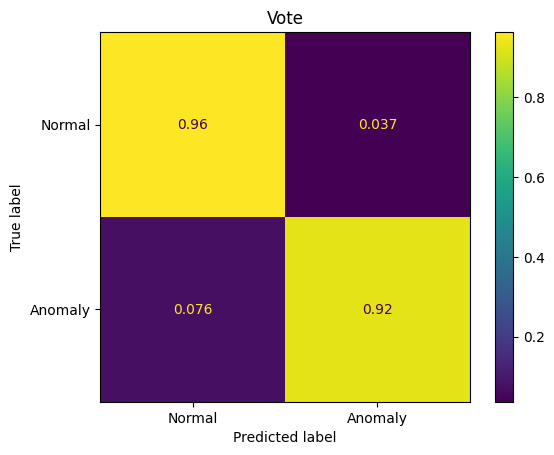

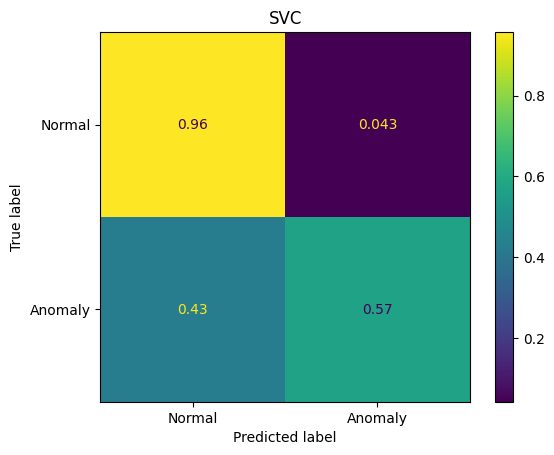

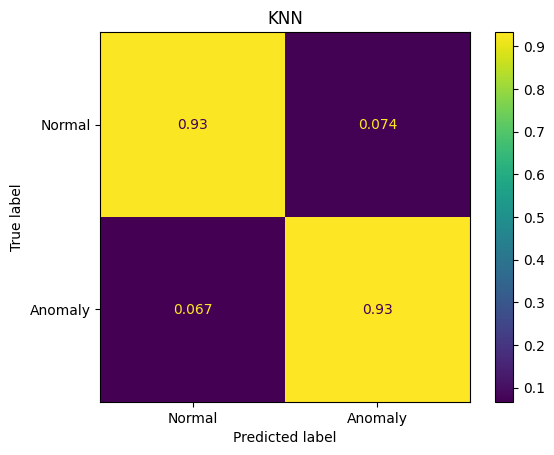

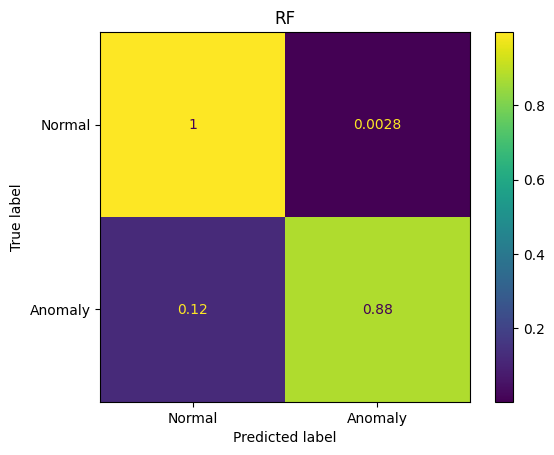

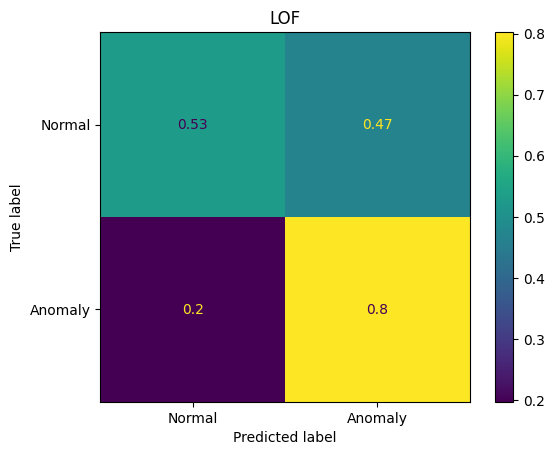

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines.items():
    
    #X, _, Y, _ = train_test_split(X_train, Y_train, train_size= sample_num, random_state=22) # sampling according to the model
    # Cross Validation
    if pipeline_name == 'LOF' :
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv= 3, scoring= custom_scorer)
    else:
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv= 3)
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_bin(pipeline_name, Y_test, Y_pred))
    print("CV Scores:", cv_scores*100)
    print("\n")

## With Feature Extraction: PCA

Model: Vote
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  94.354  98.479407  94.757906  96.582821  7.798949


Model: SVC
         Average Accuracy Score  Precision     Recall   F1-Score      FPR
Anomaly                  50.845  98.092651  42.448606  59.255145  4.39957


Model: KNN
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                   94.03  98.448086  94.398062  96.380546  7.931886


Model: RF
         Average Accuracy Score  Precision    Recall   F1-Score       FPR
Anomaly                   91.01  98.817421  90.40533  94.424391  5.766918


Model: LOF
         Average Accuracy Score  Precision     Recall   F1-Score        FPR
Anomaly                  70.898  26.378582  47.027917  33.798908  24.623826




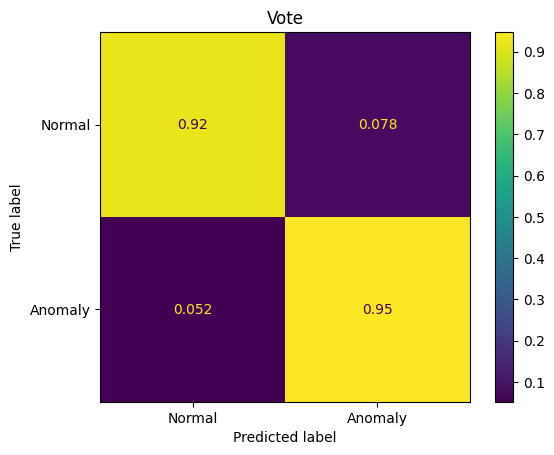

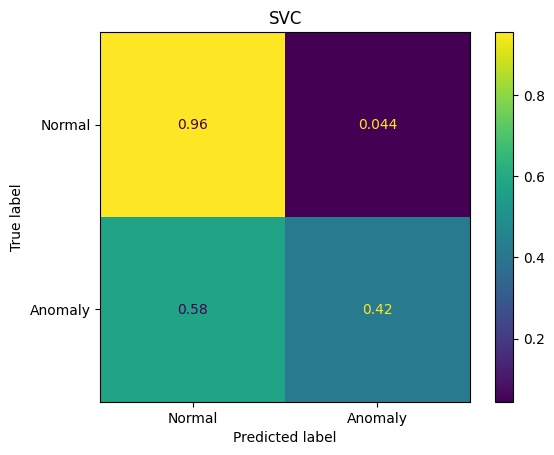

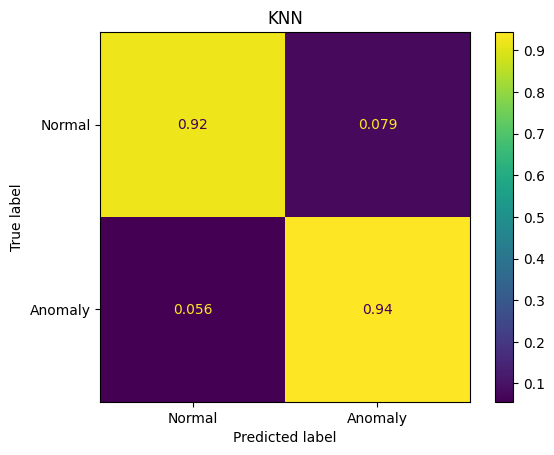

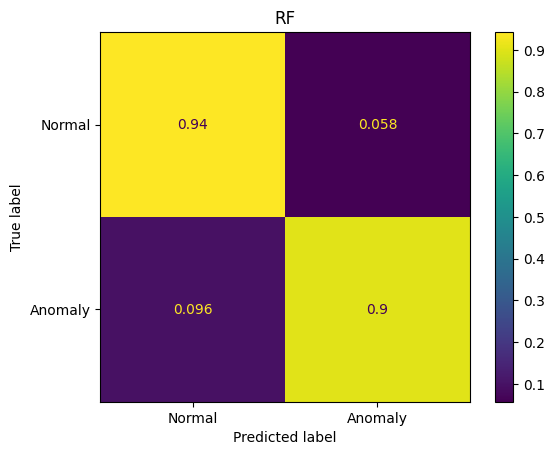

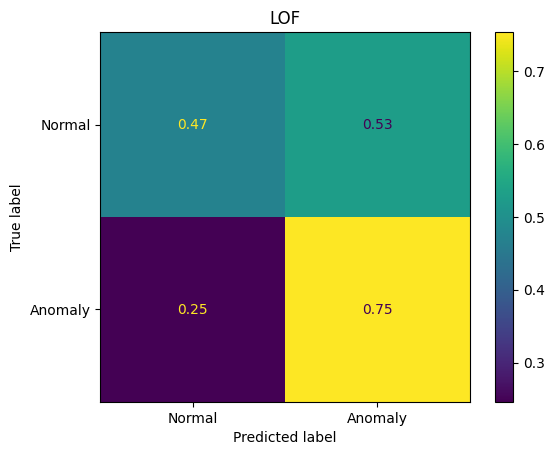

In [8]:
# Pipelines with PCA
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(8000)),
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_LOF = Pipeline([
    ('subsample', SampleSubsetSelector(6000)),
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', LocalOutlierFactor(novelty= True, leaf_size= 6, metric= 'manhattan', n_neighbors= 2))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF)], voting='soft')

# Dictionary of pipelines
pipelines_svc = {
    'Vote': Vote_clf,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'LOF': Pipeline_LOF,
    }

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_svc.items():
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_bin(pipeline_name, Y_test, Y_pred))
    print("\n")

## With Feature Selection: RF

Model: Vote
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  93.168  99.173774  92.658219  95.805346  4.114705


Model: SVC
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  58.359  98.398908  51.382967  67.511878  4.456542


Model: KNN
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  93.157   98.50765  93.286462  95.825988  7.533076


Model: RF
         Average Accuracy Score  Precision     Recall   F1-Score      FPR
Anomaly                  90.097  99.915352  88.313956  93.757131  0.39881


Model: LOF
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  59.447   20.26092  53.383554  29.373552  39.41546




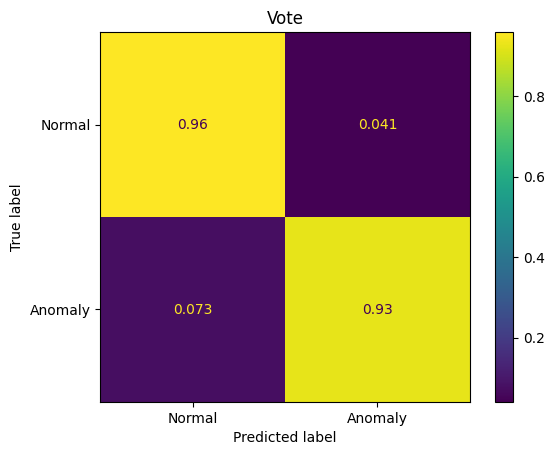

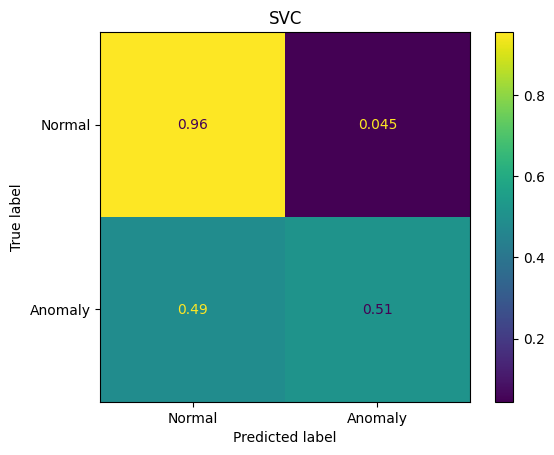

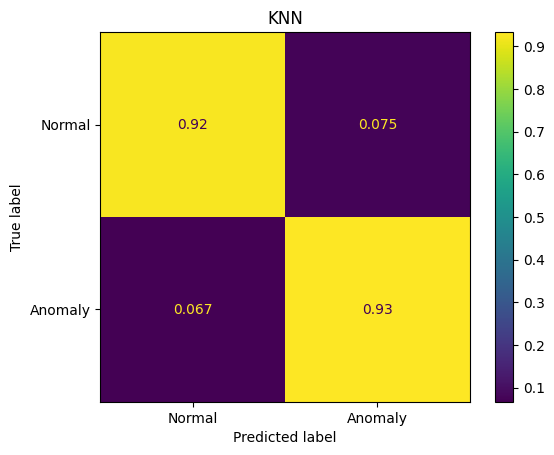

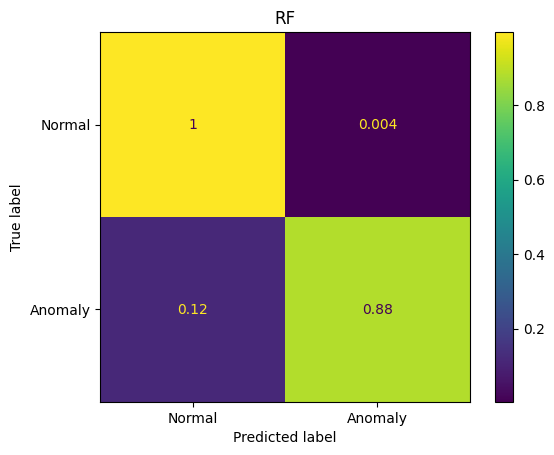

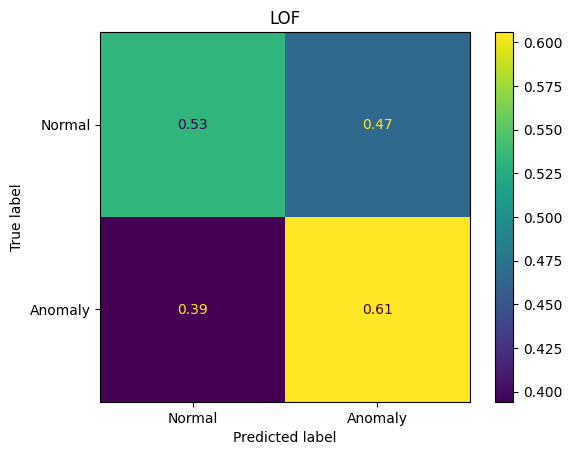

In [11]:
# Pipelines with Feature Selection
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_pass_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(8000)),
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_LOF = Pipeline([
    ('subsample', SampleSubsetSelector(6000)),
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', LocalOutlierFactor(novelty= True, leaf_size= 6, metric= 'manhattan', n_neighbors= 2))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF)], voting='soft')

# Dictionary of pipelines
pipelines_FS = {
    'Vote': Vote_clf,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'LOF': Pipeline_LOF,
    }

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_FS.items():
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_bin(pipeline_name, Y_test, Y_pred))
    print("\n")

# Multiclass Pipelines

## Normal

In [5]:
# Encoders and Scalers
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
numerical_transformer_std = StandardScaler()
categorical_transformer_tar = TargetEncoder()

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('Robust Scaling numerical features', numerical_transformer_rob, numerical_features), # robust scaling
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])
transformer_pass_tar = ColumnTransformer(
    transformers=[
        ('passthrough numerical features', 'passthrough', numerical_features), # passthrough
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])

# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'Vote': Vote_clf
    }


Model: SVC
   Accuracy  Precison    Recall  F1-Score
1   0.68859  0.991496  0.755608  0.857627
2   0.68859  0.719281  0.874799  0.789454
3   0.68859  0.878049  0.911392  0.894410
4   0.68859  0.479073  0.575349  0.522815
5   0.68859  0.541997  0.707803  0.613902
6   0.68859  0.763948  0.514022  0.614546
CV Scores: [67.48 68.62 69.42]


Model: LinSVC
   Accuracy  Precison    Recall  F1-Score
1    0.6036  0.980724  0.569860  0.720858
2    0.6036  0.526843  0.876635  0.658149
3    0.6036  1.000000  0.814346  0.897674
4    0.6036  0.484586  0.385899  0.429648
5    0.6036  0.439738  0.811150  0.570305
6    0.6036  0.894244  0.459264  0.606859
CV Scores: [59.46 60.26 60.24]


Model: KNN
   Accuracy  Precison    Recall  F1-Score
1   0.82663  0.955270  0.799560  0.870506
2   0.82663  0.732740  0.875029  0.797588
3   0.82663  1.000000  0.911392  0.953642
4   0.82663  0.723250  0.807406  0.763014
5   0.82663  0.872029  0.823011  0.846811
6   0.82663  0.794796  0.868203  0.829879
CV Scores: [82.3

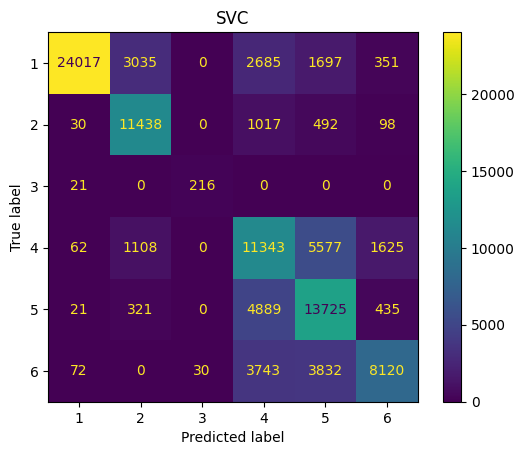

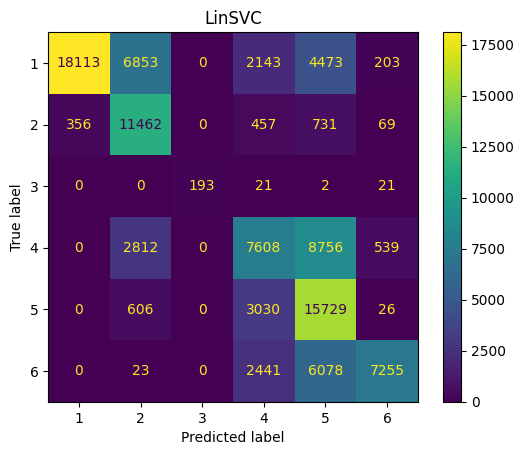

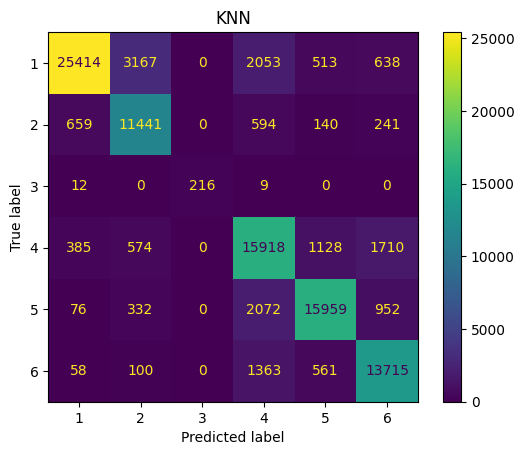

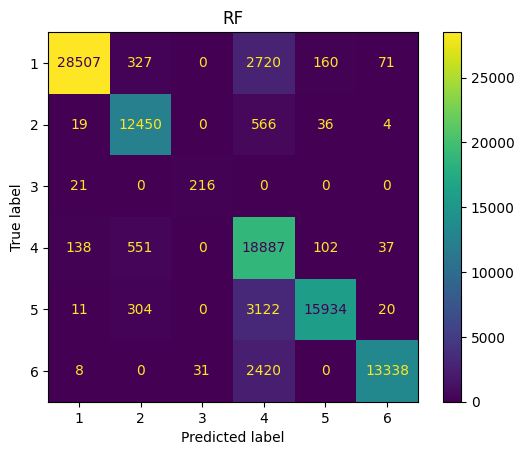

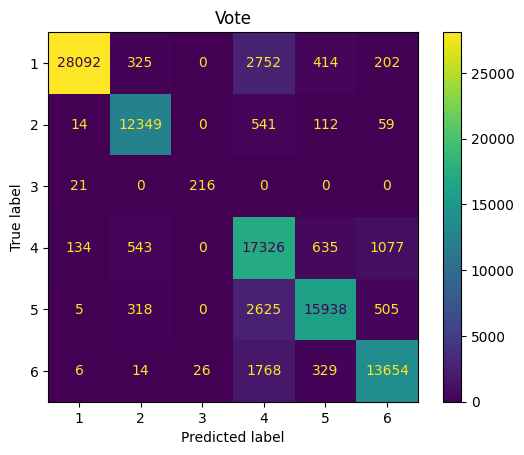

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)

#for pipeline_name, (pipeline, sample_num) in pipelines.items():
for pipeline_name, pipeline in pipelines.items():
    
    #X, _, Y, _ = train_test_split(X_train, Y_train, train_size= sample_num, random_state=22) # sampling according to the model
    
    # Cross Validation
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv= 3)
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_clf(pipeline, pipeline_name, Y_test, Y_pred))
    print("CV Scores:", cv_scores*100)
    print("\n")

## With Feature Extraction: PCA

Model: SVC
   Accuracy  Precison    Recall  F1-Score
1    0.5544  0.896951  0.609847  0.726047
2    0.5544  0.393565  0.863556  0.540705
3    0.5544  0.896266  0.911392  0.903766
4    0.5544  0.578857  0.170530  0.263449
5    0.5544  0.423517  0.777165  0.548259
6    0.5544  0.758180  0.387225  0.512634


Model: LinSVC
   Accuracy  Precison    Recall  F1-Score
1   0.45139  0.712112  0.756741  0.733748
2   0.45139  0.604460  0.219732  0.322302
3   0.45139  0.886364  0.822785  0.853392
4   0.45139  0.868132  0.008014  0.015882
5   0.45139  0.293197  0.632768  0.400718
6   0.45139  0.290858  0.353865  0.319283


Model: KNN
   Accuracy  Precison    Recall  F1-Score
1   0.82813  0.930565  0.802391  0.861738
2   0.82813  0.649854  0.865163  0.742209
3   0.82813  0.823970  0.928270  0.873016
4   0.82813  0.744552  0.802333  0.772363
5   0.82813  0.896847  0.842040  0.868580
6   0.82813  0.881239  0.862885  0.871965


Model: RF
   Accuracy  Precison    Recall  F1-Score
1   0.82381  0.961433  0

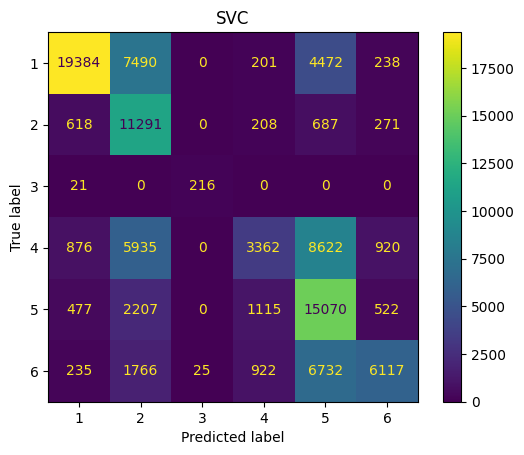

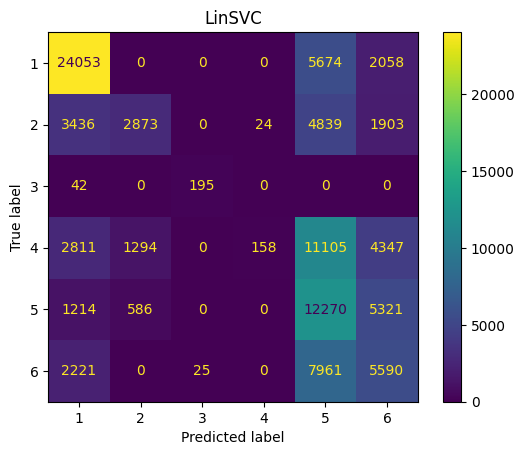

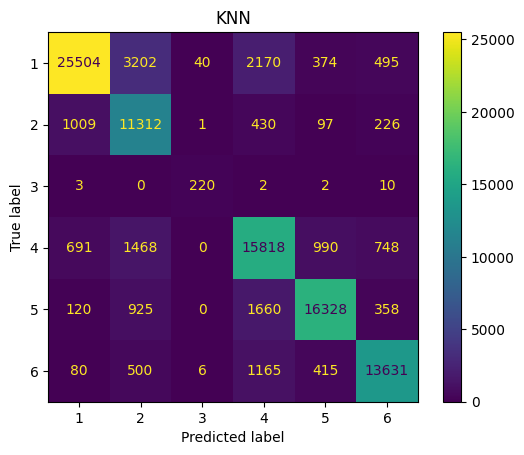

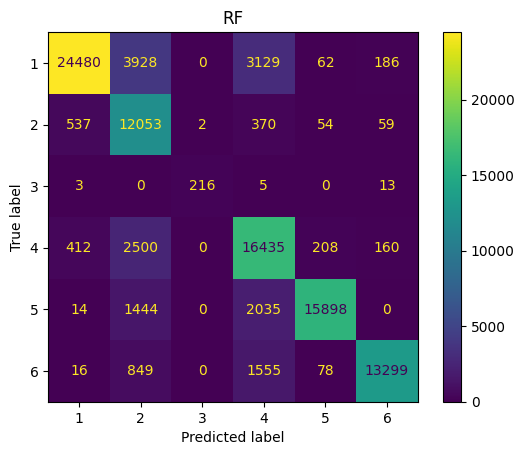

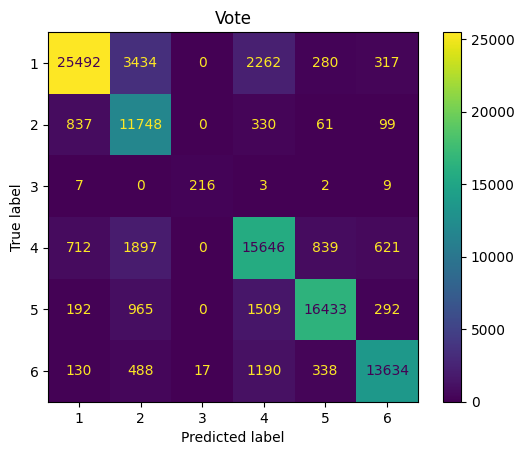

In [13]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines_svc = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'Vote': Vote_clf
    }

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_svc.items():
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_clf(pipeline, pipeline_name, Y_test, Y_pred))
    print("\n")

## With Feature Selection: RF

Model: SVC
   Accuracy  Precison    Recall  F1-Score
1   0.70082  0.992435  0.759446  0.860448
2   0.70082  0.730884  0.879465  0.798320
3   0.70082  1.000000  0.911392  0.953642
4   0.70082  0.473361  0.638144  0.543538
5   0.70082  0.620993  0.674282  0.646541
6   0.70082  0.708723  0.542635  0.614657


Model: LinSVC
   Accuracy  Precison    Recall  F1-Score
1   0.57019  0.981793  0.570017  0.721272
2   0.57019  0.410716  0.891702  0.562394
3   0.57019  1.000000  0.911392  0.953642
4   0.57019  0.577935  0.173776  0.267207
5   0.57019  0.419850  0.841628  0.560228
6   0.57019  0.893910  0.460847  0.608162


Model: KNN
   Accuracy  Precison    Recall  F1-Score
1   0.82767  0.952468  0.800661  0.869992
2   0.82767  0.732565  0.874876  0.797421
3   0.82767  1.000000  0.911392  0.953642
4   0.82767  0.719178  0.814862  0.764036
5   0.82767  0.881838  0.820535  0.850083
6   0.82767  0.801863  0.866430  0.832897


Model: RF
   Accuracy  Precison    Recall  F1-Score
1   0.89327  0.992340  0

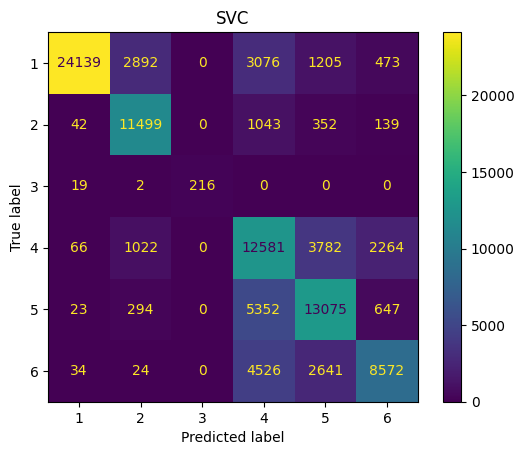

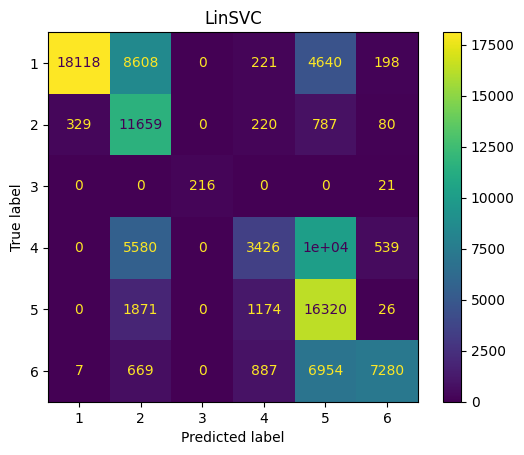

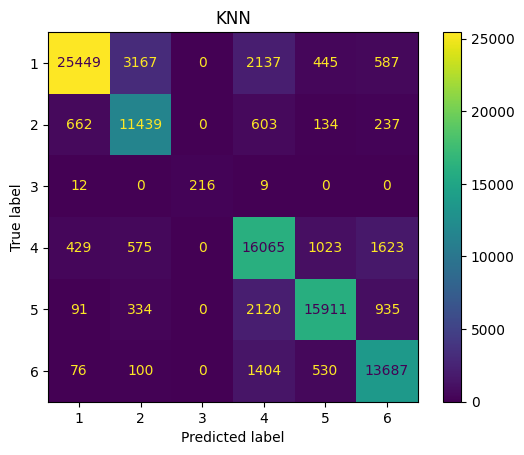

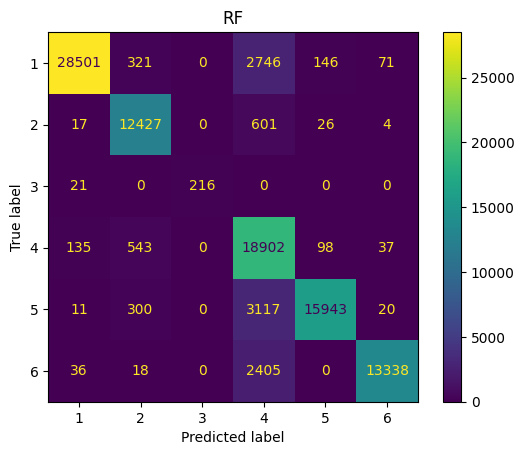

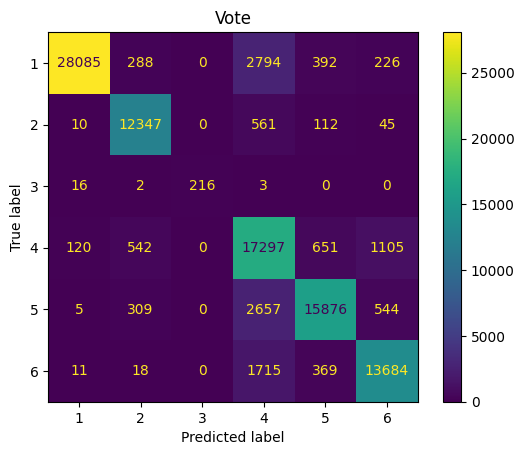

In [14]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('scale', StandardScaler()),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines_FS = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'Vote': Vote_clf
    }

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_FS.items():
    # Training
    pipeline.fit(X_train, Y_train)
    # Testing
    Y_pred = pipeline.predict(X_test)

    print(f"Model: {pipeline_name}")
    print(evaluate_clf(pipeline, pipeline_name, Y_test, Y_pred))
    print("\n")

# Novel Attack test

## Multiclass

In [112]:
#Function to remove a attack type from the dataframe
def remove_attack_type(X, Y, type: int):
    indices_to_remove = Y[Y == type].index
    return X.drop(indices_to_remove), Y.drop(indices_to_remove)

#Function training and testing novel classes in multiclass Models
def train_eval_novel(model, x, y, novel_class: int):
    y_pred = model.fit(x, y).predict(X_test) # Predicting the test set

    novel_indices = np.where(Y_test == novel_class)[0]
    labels = np.arange(1,7)
    percentage = pd.DataFrame(columns= labels)
    # Calculating the percentage Novel Class subset in other classes
    for i in np.delete(labels, novel_class-1):
        percentage[i] = [(np.where(y_pred[novel_indices] == i)[0].shape[0]/novel_indices.shape[0])*100]
    percentage.index = [novel_class]
    
    return percentage 

In [102]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines = {
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'Vote': Vote_clf
    }


In [103]:
X, X_test, Y, Y_test = train_test_split(Data, Attack_type, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)

#Training set without the novel attack types
X_train_nov1, Y_train_nov1 = remove_attack_type(X, Y, 1)
X_train_nov2, Y_train_nov2 = remove_attack_type(X, Y, 2)
X_train_nov3, Y_train_nov3 = remove_attack_type(X, Y, 3)
X_train_nov4, Y_train_nov4 = remove_attack_type(X, Y, 4)
X_train_nov5, Y_train_nov5 = remove_attack_type(X, Y, 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]


Results_Multiclassifier_Novel = pd.DataFrame()

for pipeline_name, pipeline in pipelines.items():
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_eval_novel(pipeline, x, y, i+1)], axis=0)
    Results_Multiclassifier_Novel = pd.concat([Results_Multiclassifier_Novel, pd.concat([result], keys=[pipeline_name])])
    
Results_Multiclassifier_Novel.index.names = ['Model', 'Novel classs']
Results_Multiclassifier_Novel

1          2    3          4          5  \
Model Novel classs                                                     
KNN   1                    NaN  47.896807  0.0  45.722825   2.752871   
      2              37.590822        NaN  0.0  26.034417  33.889101   
      3               6.329114   0.000000  NaN   2.531646  91.139241   
      4              19.660157  18.691352  0.0        NaN  37.945727   
      5               3.254087   9.463153  0.0  57.186324        NaN   
RF    1                    NaN  70.838446  0.0  24.772692   3.051754   
      2              27.487572        NaN  0.0  36.229446  15.105163   
      3             100.000000   0.000000  NaN   0.000000   0.000000   
      4              16.804464  14.587877  0.0        NaN  52.843013   
      5               2.671342   9.390955  0.0  86.220412        NaN   
Vote  1                    NaN  51.713072  0.0  40.163599   6.644644   
      2              29.460803        NaN  0.0  67.472275   2.057361   
      3               8.438819   0.000000  NaN   0.421941  91.139241   
      4               2.941922  22.617296  0.0        NaN  56.063911   
      5              12.392347   4.636171  0.0  66.438038        NaN   

                            6  
Model Novel classs             
KNN   1              3.627497  
      2              2.485660  
      3              0.000000  
      4             23.702764  
      5             30.096436  
RF    1              1.337109  
      2             21.177820  
      3              0.000000  
      4             15.764646  
      5              1.717292  
Vote  1              1.478685  
      2              1.009560  
      3              0.000000  
      4             18.376870  
      5             16.533443

## Binary class

In [6]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('subsample', SampleSubsetSelector(2500)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('subsample', SampleSubsetSelector(8000)),
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('RF', Pipeline_RF)], voting='soft')

# Dictionary of pipelines
pipelines = {
    'Vote': Vote_clf,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    }

In [7]:
_, _, Y_ref_train, Y_ref_test = train_test_split(Data, Attack_type, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)
X, X_test, Y, Y_test = train_test_split(Data, Attack_label, train_size=15000, test_size=100000, random_state=22, stratify= Attack_type)

#Function to remove a attack type from the dataframe
def remove_attack_type(X, Y, type: int):
    indices_to_remove = Y[Y_ref_train == type].index
    return X.drop(indices_to_remove), Y.drop(indices_to_remove)

def train_eval_novel_bin(model_name, model, x, y, novel_class: int):
    y_pred = model.fit(x, y).predict(X_test) # Predicting the test set

    novel_indices = np.where(Y_ref_test == novel_class)[0]
    percentage = pd.DataFrame(columns= ['Percentage of True Positives from Novel Class'])
    percentage['Percentage of True Positives from Novel Class'] = [(np.where(y_pred[novel_indices] == 1)[0].shape[0]/novel_indices.shape[0])*100] # Calculating the percentage of True Positives from Novel Class
    percentage.index = ['Anomaly']
    result = evaluate_bin(model_name, Y_test, y_pred, display=False) # Evaluating the model
    result = pd.concat([result, percentage], axis=1) # Concatenating the percentage to the evaluation result
    result.index = [novel_class] # Setting the index to the Novel Class	
    return result

#Training set without the novel attack types
X_train_nov1, Y_train_nov1 = remove_attack_type(X, Y, 1)
X_train_nov2, Y_train_nov2 = remove_attack_type(X, Y, 2)
X_train_nov3, Y_train_nov3 = remove_attack_type(X, Y, 3)
X_train_nov4, Y_train_nov4 = remove_attack_type(X, Y, 4)
X_train_nov5, Y_train_nov5 = remove_attack_type(X, Y, 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]


Results_Binaryclassifier_Novel = pd.DataFrame()

for pipeline_name, pipeline in pipelines.items():
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_eval_novel_bin(pipeline_name, pipeline, x, y, i+1)], axis=0)
    Results_Binaryclassifier_Novel = pd.concat([Results_Binaryclassifier_Novel, pd.concat([result], keys=[pipeline_name])])
    
Results_Binaryclassifier_Novel.index.names = ['Model', 'Novel classs']
Results_Binaryclassifier_Novel


Average Accuracy Score  Precision     Recall   F1-Score  \
Model Novel classs                                                            
Vote  1                             91.046  99.131616  90.155933  94.430969   
      2                             93.442  99.161696  92.997874  95.980928   
      3                             92.710  99.238185  92.048977  95.508484   
      4                             89.837  99.375800  88.486158  93.615364   
      5                             84.564  99.208564  82.324858  89.981568   
SVC   1                             79.846  89.460908  86.222581  87.811899   
      2                             63.152  98.576206  57.063288  72.283484   
      3                             63.708  98.488007  57.786540  72.836956   
      4                             62.996  98.573634  56.876833  72.133024   
      5                             63.161  98.594410  57.063288  72.288377   
KNN   1                             90.532  98.299016  90.318635  94.140001   
      2                             93.277  98.455285  93.482417  95.904431   
      3                             92.809  98.458383  92.914742  95.606269   
      4                             89.957  99.032053  88.942199  93.716331   
      5                             84.668  98.777568  82.816527  90.095607   
RF    1                             89.588  99.886424  87.734404  93.416876   
      2                             88.850  99.888004  86.855575  92.917037   
      3                             89.627  99.910765  87.759343  93.441659   
      4                             89.667  99.910813  87.806848  93.468601   
      5                             89.633  99.943182  87.737967  93.443712   

                          FPR  Percentage of True Positives from Novel Class  
Model Novel classs                                                            
Vote  1              4.209660                                      96.347334  
      2              4.190669                                      98.875717  
      3              3.766538                                     100.000000  
      4              2.962588                                      71.767690  
      5              3.500665                                      46.165747  
SVC   1             54.143192                                      71.882964  
      2              4.393239                                      92.787763  
      3              4.728746                                      64.978903  
      4              4.386909                                      30.631499  
      5              4.336266                                      13.691919  
KNN   1              8.330696                                      95.192701  
      2              7.817940                                      97.040153  
      3              7.754637                                     100.000000  
      4              4.633791                                      73.289374  
      5              5.463063                                      47.274509  
RF    1              0.531747                                      93.311310  
      2              0.519086                                      87.969407  
      3              0.417801                                     100.000000  
      4              0.417801                                      73.903119  
      5              0.265873                                      85.611882

<Axes: title={'center': 'Binary Classifier Novel Class detected'}, xlabel='Model', ylabel='Percentage'>

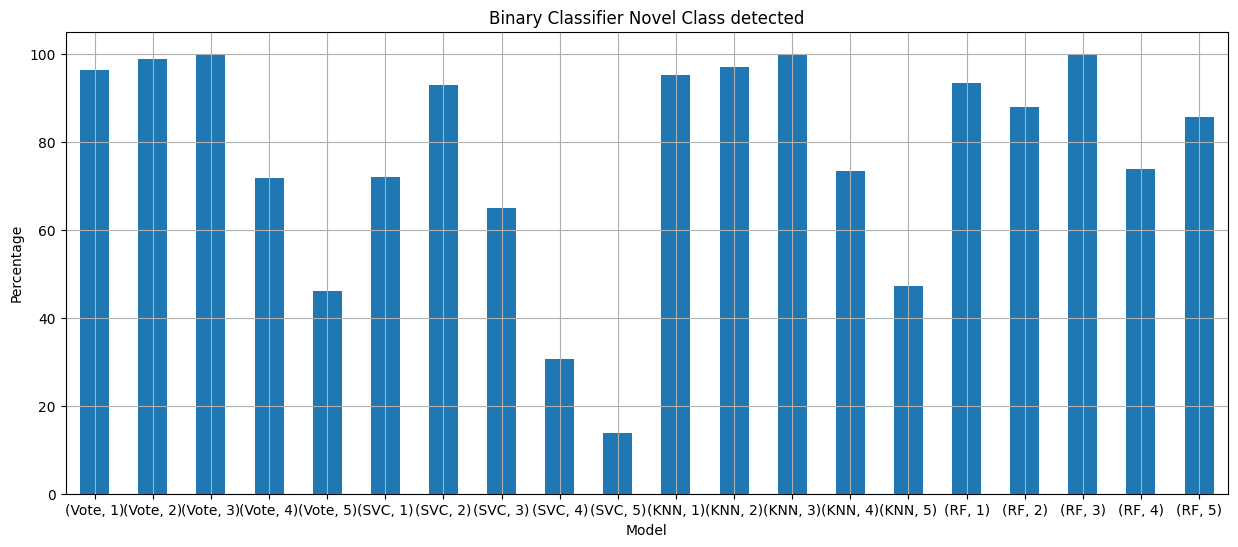

In [13]:
Results_Binaryclassifier_Novel['Percentage of True Positives from Novel Class'].plot(kind='bar', figsize=(15, 6), title='Binary Classifier Novel Class detected', ylabel='Percentage', xlabel='Model', rot=0, grid=True, colormap='tab20')